In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re
import netCDF4 as nc

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))


from gridtools.b2_tools import *
from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from code_comparison.viewer_2d import *
from code_comparison.code_comparison import *
from code_comparison.solps_pp import *

from gridtools.solps_python_scripts.read_b2fgmtry import *


%load_ext autoreload
%autoreload 2
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


In [2]:
path=os.path.join(r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19")

### Isolate SOLPS extents
- Keep the plot please... the index of the upper target was found manually

b2fgmtry loaded from .pkl
(38, 112)
112 38


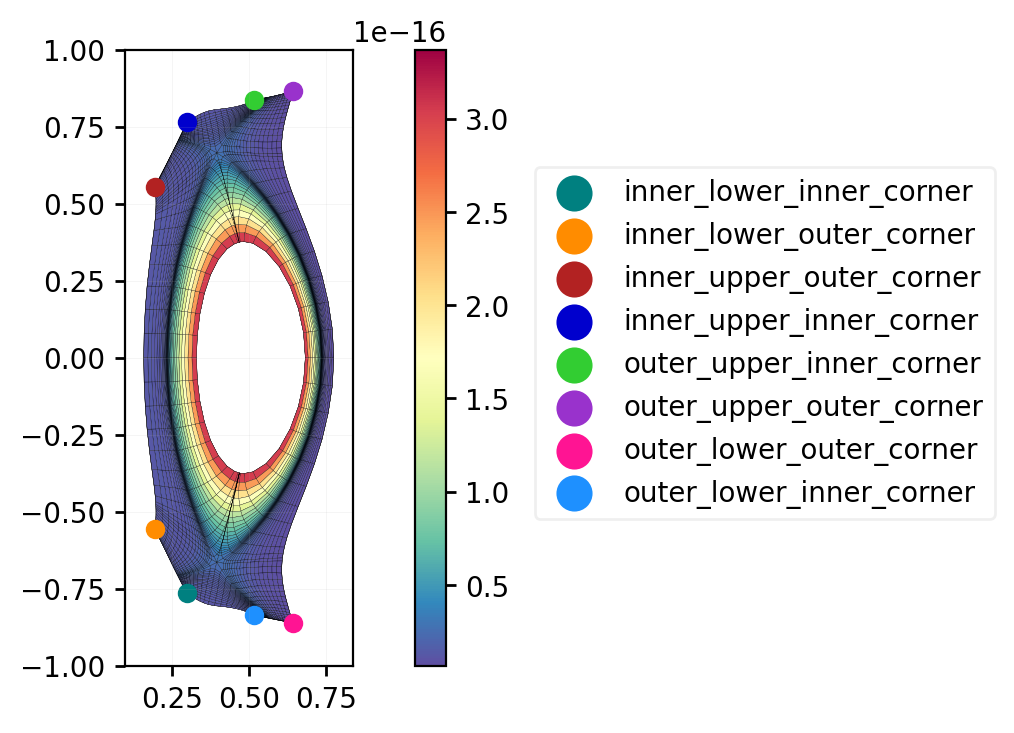

In [3]:
path_solps = os.path.join(r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16")

with nc.Dataset(os.path.join(path_solps, "balance.nc")) as d:
    crx = d["crx"]
    cry = d["cry"]

g = read_b2fgmtry(where=path_solps)
spc = SOLPScase(path_solps)


plt.close("all")
fig, ax = plt.subplots(dpi = 200, figsize = (8,4))
spc.plot_2d("ti", fig = fig, ax = ax, antialias = True, linewidth = 0.1)
ax.set_ylim(-1,1)

upper_break = int(np.mean([g["rightcut"][1], g["leftcut"][0]]))

# upper_break = g["rightcut"].max() - g["leftcut"].min()


# upper_break = g["rightcut"].min() - g["leftcut"].max() +4 

bounds = {
    # It' [corner, radial(logical y), poloidal(logical x)]
    "inner_lower_inner_corner" : [1, 0, 0],
    "inner_lower_outer_corner" : [1, -1, 0],
    "inner_upper_outer_corner" : [1, -1, upper_break + 10],
    "inner_upper_inner_corner" : [1, 0, upper_break + 10],
    "outer_upper_inner_corner" : [1, 0, upper_break + 11],
    "outer_upper_outer_corner" : [1, -1, upper_break + 11],
    "outer_lower_outer_corner" : [1, -1, -1],
    "outer_lower_inner_corner" : [1, 0, -1],
}
rz_extents = dict()

for name in bounds:
    p1 = bounds[name]
    rz_extents[name] = dict()
    rz_extents[name]["R"] = crx[p1[0], p1[1], p1[2]]
    rz_extents[name]["Z"] = cry[p1[0], p1[1], p1[2]]
    
    ax.scatter(crx[p1[0], p1[1], p1[2]], cry[p1[0], p1[1], p1[2]], label = name)
    
fig.legend(loc = "upper left", bbox_to_anchor=(0.85, 0.75))

In [4]:

plt.close("all")
from plot1d_wall_fluxes import *
self = SOLEDGEcase(path)
wfluxes_all = self.get_wall_fluxes(verbose = True)

# fig, ax = plt.subplots()
# ax.plot(wfluxes_all["L"], wfluxes_all["pflux_i"])

wfluxes = dict()
df = wfluxes_all.copy()
# wfluxes["all"] = wfluxes_all.copy()
wfluxes["inner_lower_target"] = df.query(f"Z < {rz_extents['inner_lower_outer_corner']['Z']} & R < {rz_extents['inner_lower_inner_corner']['R']}")
wfluxes["inner_wall"] = df.query(f"Z > {rz_extents['inner_lower_outer_corner']['Z']} & R < {rz_extents['inner_upper_outer_corner']['R']} & Z < {rz_extents['inner_upper_outer_corner']['Z']}")
wfluxes["inner_upper_target"] = df.query(f"Z > {rz_extents['inner_upper_outer_corner']['Z']} & R < {rz_extents['inner_upper_inner_corner']['R']}")
wfluxes["upper_pfr"] = df.query(f"R > {rz_extents['inner_upper_inner_corner']['R']} & R < {rz_extents['outer_upper_inner_corner']['R']} & Z > 0")
wfluxes["outer_upper_target"] = df.query(f"R > {rz_extents['outer_upper_inner_corner']['R']} & R < {rz_extents['outer_upper_outer_corner']['R']} & Z > {rz_extents['outer_upper_inner_corner']['Z']}")
wfluxes["lower_pfr"] = df.query(f"R > {rz_extents['inner_upper_inner_corner']['R']} & R < {rz_extents['outer_upper_inner_corner']['R']} & Z < 0")
wfluxes["outer_lower_target"] = df.query(f"R > {rz_extents['outer_lower_inner_corner']['R']} & R < {rz_extents['outer_lower_outer_corner']['R']} & Z < {rz_extents['inner_lower_inner_corner']['Z']}")

# Now going by index. Note that SOLEDGE goes anticlockwise, but we go clockwise...
wfluxes["upper_chamber"] = df.query(f"index < {wfluxes['outer_upper_target'].index[0]} & index > {wfluxes['outer_upper_target'].index[0]} - 45")
wfluxes["upper_baffle"] = df.query(f"index < {wfluxes['upper_chamber'].index[0]} & index > {wfluxes['upper_chamber'].index[0]} - 16")

wfluxes["lower_chamber"] = df.query(f"index > {wfluxes['outer_lower_target'].index[-1]} & index < {wfluxes['outer_lower_target'].index[-1]} + 45 + 2")    # Asymmetric offset due to oddities in SOLEDGE grid
wfluxes["lower_baffle"] = df.query(f"index > {wfluxes['lower_chamber'].index[-1]} & index < {wfluxes['lower_chamber'].index[-1]} + 16 - 2")

# Index starts at OMP, so there is index discontinuity in the middle
# wfluxes["outer_lower_wall"] = df.query(f"index > {wfluxes['lower_baffle'].index[-1]}")# & index < {wfluxes['upper_baffle'].index[0]}")
wfluxes["outer_wall"] = df.query(f"index < {wfluxes['upper_baffle'].index[0]} & index > {wfluxes['lower_baffle'].index[-1]} ")


        


c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


get_wall_triangle
get_wall_triangles
get_wall_triangles.2: Completed
get_wall_triangle: Completed

### TOTAL WALL INTEGRALS------------

### Heat flows:
E_incident_Electron: ---- 0.56 [MW]
E_incident_Ions: ---- 0.83 [MW]
E_Total: ---- 1.62 [MW]
E_incident_Atoms: ---- 0.46 [MW]
E_Radiation_Atoms: ---- 0.07 [MW]
E_Rad_Recombination: ---- -0.40 [MW]
E_Recombination_in_Wall: ---- 0.11 [MW]
E_incident_Molecules: ---- 0.00 [MW]
E_incident_Ions_EIRENE: ---- 1.13 [MW]
E_Radiation: ---- 0.07 [MW]

### Particle flows:
F_Ion_Incident: ---- 4.676e+22 [s-1]
F_Atom_Emitted_from_Ion: ---- 2.831e+22 [s-1]
F_Atom_Incident: ---- 9.718e+22 [s-1]
F_Mol_Incident: ---- 4.350e+22 [s-1]
F_Mol_Emitted_from_Ion: ---- 9.226e+21 [s-1]
F_Atom_Emitted_from_Atom: ---- 7.193e+22 [s-1]
F_Mol_Emitted_from_Atom: ---- 1.237e+22 [s-1]


No duplicates found


Text(0, 0.5, 'Z [m]')

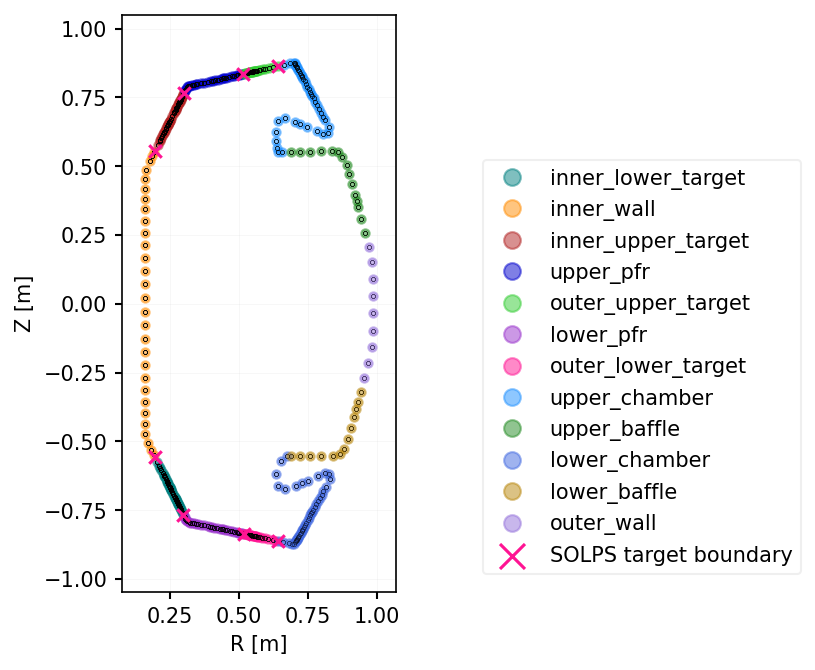

In [6]:
%matplotlib inline
fig, ax = plt.subplots(dpi = 150)

for region in wfluxes.keys():
    
# for region in [
#     # 'inner_lower_target', 
#     # 'inner_wall', 
#     # 'inner_upper_target', 
#     # 'upper_pfr', 
#     # 'outer_upper_target', 
#     # 'lower_pfr', 
#     # 'outer_lower_target', 
#     # 'upper_chamber', 
#     # 'upper_baffle', 
#     # 'lower_chamber', 
#     # 'lower_baffle', 
#     'outer_lower_wall', 
#     # 'outer_upper_wall'
#                ]:

    ax.plot(df["R"], df["Z"], c = "k", alpha = 1, lw = 0, marker = "o", markersize = 2, markeredgewidth=0.1, markerfacecolor="None")
    if region != "wall":
        ax.plot(wfluxes[region]["R"], wfluxes[region]["Z"],  alpha = 0.5, lw = 0,  label = region, markersize = 4, marker = "o")
           
for i, name in enumerate(rz_extents.keys()):
    label = "SOLPS target boundary" if i == 0 else ""
    ax.scatter(rz_extents[name]["R"], rz_extents[name]["Z"], marker = "x", c = "deeppink", label = label, zorder = 100)
    
# Plot duplicates if any
allregions = pd.concat(wfluxes.values())
dupl = allregions[allregions.duplicated(subset="R")]
if len(dupl) > 0:
    ax.scatter(dupl["R"], dupl["Z"], c = "r", edgecolors="yellow", s = 50, label = "DUPLICATES", zorder = 200)
else:
    print("No duplicates found")
    
ax.set_aspect("equal")
fig.legend(loc="upper left", bbox_to_anchor=(0.75, 0.7))
ax.set_xlabel("R [m]")
ax.set_ylabel("Z [m]")

In [7]:
wfluxes[region].keys()

Index(['iTri', 'iSide', 'iProp', 'dlSurf', 'dlWall', 'Area', 'R', 'Z',
       'F_Ion_Incident', 'F_Atom_Emitted_from_Ion', 'F_Atom_Incident',
       'F_Mol_Incident', 'F_Mol_Emitted_from_Ion', 'F_Atom_Emitted_from_Atom',
       'F_Mol_Emitted_from_Atom', 'E_incident_Electron', 'E_incident_Ions',
       'E_Total', 'E_incident_Atoms', 'E_Radiation_Atoms',
       'E_Rad_Recombination', 'E_Recombination_in_Wall',
       'E_incident_Molecules', 'E_incident_Ions_EIRENE', 'E_Radiation'],
      dtype='object')

Text(0.5, 1.0, 'F_Ion_Incident')

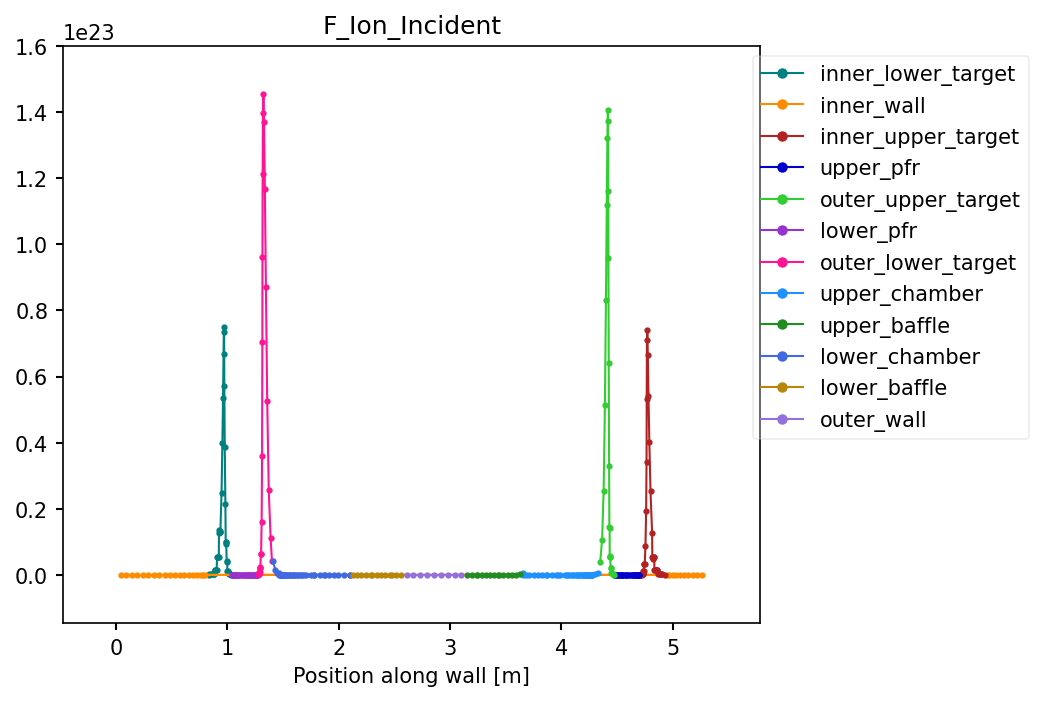

In [8]:
%matplotlib inline
fig, ax = plt.subplots(dpi = 150)
param = "F_Ion_Incident"
for region in wfluxes.keys():
    ax.plot(wfluxes[region]["dlWall"], wfluxes[region][param], label = region, marker = "o", lw = 1, markersize = 2)
    
ax.legend(loc="upper right", bbox_to_anchor=(1.4,1))
ax.grid()

ax.set_xlabel("Position along wall [m]")
ax.set_yscale("linear")
ax.set_title(param)
# ax.set_xlim(3.6,3.7)

# Wall integrals

In [9]:
wfluxes_integral.loc[region, param] = 5

NameError: name 'wfluxes_integral' is not defined

In [ ]:
import copy
df = pd.DataFrame()
wfluxes_integral = pd.DataFrame()

params = [x for x in wfluxes_all.columns if x not in ["R", "Z", 'iTri', 'iSide', 'iProp', 'dlSurf', 'dlWall', 'Area']]

for region in wfluxes.keys():
    for param in params:
        wfluxes_integral.loc[region, param] = (wfluxes[region][param] * wfluxes[region]["Area"]).sum()



In [ ]:
wfsums = pd.DataFrame(columns = wfluxes_integral.columns)
wfsums.loc["outer_lower_target", :] = wfluxes_integral.loc["outer_lower_target", :]
wfsums.loc["inner_lower_target", :] = wfluxes_integral.loc["inner_lower_target", :]
wfsums.loc["all_targets", :] = wfluxes_integral.loc[["outer_lower_target", "inner_lower_target", "outer_upper_target", "inner_upper_target"], :].sum(axis=0)
wfsums.loc["all_walls", :] = wfluxes_integral.sum(axis=0)
display_dataframe(wfsums.transpose())

,outer_lower_target,inner_lower_target,all_targets,all_walls
F_Ion_Incident,1.95e+22,3.99e+21,4.62e+22,4.68e+22
F_Atom_Emitted_from_Ion,1.19e+22,2.33e+21,2.79e+22,2.83e+22
F_Atom_Incident,9.08e+21,1.17e+21,1.86e+22,9.72e+22
F_Mol_Incident,1.49e+21,6.91e+18,2.50e+21,4.35e+22
F_Mol_Emitted_from_Ion,3.80e+21,8.29e+20,9.15e+21,9.23e+21
F_Atom_Emitted_from_Atom,7.05e+21,9.07e+20,1.45e+22,7.19e+22
F_Mol_Emitted_from_Atom,1.01e+21,1.32e+20,2.07e+21,1.24e+22
E_incident_Electron,2.25e+05,5.31e+04,5.55e+05,5.55e+05
E_incident_Ions,3.07e+05,9.26e+04,8.24e+05,8.26e+05
E_Total,4.47e+05,1.26e+05,1.16e+06,1.62e+06


In [22]:
### Energy
dfE = pd.DataFrame(wfluxes_integral.copy())
dfE.rename({"outer_lower_target" : "SOLEDGE"}, inplace = True, axis=1)
dfE = dfE.transpose()[["E_Total", "E_incident_Electron", "E_incident_Ions", "E_incident_Atoms", "E_incident_Molecules", "E_Radiation", "E_Radiation_Atoms", "E_Rad_Recombination", "E_Recombination_in_Wall"]] * 1e-6


#### Fluxes
dfF = pd.DataFrame(wfluxes_integral.copy()) * constants("q_e")
dfF.rename({"outer_lower_target" : "SOLEDGE"}, inplace = True, axis=1)
dfF = dfF.transpose()[['F_Ion_Incident', 'F_Atom_Emitted_from_Ion', 'F_Atom_Incident', 'F_Mol_Incident', 'F_Mol_Emitted_from_Ion', 'F_Atom_Emitted_from_Atom', 'F_Mol_Emitted_from_Atom']]

df = pd.concat([dfE, dfF], axis = 1)


KeyError: "None of [Index(['E_Total', 'E_incident_Electron', 'E_incident_Ions', 'E_incident_Atoms',\n       'E_incident_Molecules', 'E_Radiation', 'E_Radiation_Atoms',\n       'E_Rad_Recombination', 'E_Recombination_in_Wall'],\n      dtype='object')] are in the [columns]"

# SOLPS vs SOLEDGE E and F fluxes on target

In [1]:
### Energy
dfE = pd.DataFrame(wfluxes_integral.loc["outer_lower_target"].copy())
dfE.rename({"outer_lower_target" : "SOLEDGE"}, inplace = True, axis=1)
dfE = dfE.transpose()[["E_Total", "E_incident_Electron", "E_incident_Ions", "E_incident_Atoms", "E_incident_Molecules", "E_Radiation", "E_Radiation_Atoms", "E_Rad_Recombination", "E_Recombination_in_Wall"]] * 1e-6

dfE.loc["SOLPS", "E_incident_Ions"] = 4.3556e5 * 1e-6
dfE.loc["SOLPS", "E_incident_Atoms"] = 3.4572e4 * 1e-6
dfE.loc["SOLPS", "E_incident_Molecules"] = 1.0465e1 * 1e-6


dfE.loc["SOLPS", "E_Atom_Emitted_from_Ion"] = 1.5052E+05 * 1e-6
dfE.loc["SOLPS", "E_Mol_Emitted_from_Ion"] = 4.5612E+01 * 1e-6
dfE.loc["SOLPS", "E_Atom_Emitted_from_Atom"] = 1.5313E+04 * 1e-6
dfE.loc["SOLPS", "E_Mol_Emitted_from_Atom"] = 6.6536E+00 * 1e-6

dfE.loc[:, "Fraction of ion hflux recycled"] = (dfE.loc[:, "E_Atom_Emitted_from_Ion"] + dfE.loc[:, "E_Mol_Emitted_from_Ion"]) / dfE.loc[:, "E_incident_Ions"]
dfE.loc[:, "Fraction of neutral hflux reflected"] = (dfE.loc[:, "E_Atom_Emitted_from_Atom"] + dfE.loc[:, "E_Mol_Emitted_from_Atom"]) / dfE.loc[:, "E_incident_Atoms"]
# dfE.loc[:, "Average ion energy"] = 

#### Fluxes
dfF = pd.DataFrame(wfluxes_integral.loc["outer_lower_target"].copy()) * constants("q_e")
dfF.rename({"outer_lower_target" : "SOLEDGE"}, inplace = True, axis=1)
dfF = dfF.transpose()[['F_Ion_Incident', 'F_Atom_Emitted_from_Ion', 'F_Atom_Incident', 'F_Mol_Incident', 'F_Mol_Emitted_from_Ion', 'F_Atom_Emitted_from_Atom', 'F_Mol_Emitted_from_Atom']]

mult = 1/constants("q_e")
dfF.loc["SOLPS", "F_Ion_Incident"] = 1.0754E+03 *mult
dfF.loc["SOLPS", "F_Mol_Incident"] = 4.9827E+01 *mult
dfF.loc["SOLPS", "F_Atom_Incident"] = 2.8529E+02 *mult
dfF.loc["SOLPS", "F_Atom_Emitted_from_Atom"] = 2.1905E+02 *mult
dfF.loc["SOLPS", "F_Mol_Emitted_from_Atom"] = 3.3121E+01 *mult
dfF.loc["SOLPS", "F_Atom_Emitted_from_Ion"] = 6.1969E+02 *mult
dfF.loc["SOLPS", "F_Mol_Emitted_from_Ion"] = 2.2788E+02 *mult

# df.loc["SOLPS", "E_incident_Atoms"] = 3.4572e4 * 1e-6
# df.loc["SOLPS", "E_incident_Molecules"] = 1.0465e1 * 1e-6

dfF.loc[:,"Fraction of fast recycles"] = dfF.loc[:,"F_Atom_Emitted_from_Ion"] / (dfF.loc[:,"F_Mol_Emitted_from_Ion"] + dfF.loc[:,"F_Atom_Emitted_from_Ion"])
dfF.loc[:,"Fraction of fast reflections"] = dfF.loc[:,"F_Atom_Emitted_from_Atom"] / (dfF.loc[:,"F_Mol_Emitted_from_Atom"] + dfF.loc[:,"F_Atom_Emitted_from_Atom"])

#### Merge
df = pd.concat([dfE, dfF], axis = 1)
df["Average ion energy"] = (df["E_incident_Ions"] * 1e6) / (df["F_Ion_Incident"] / constants("q_e"))   # W / s-1 = J 
df["Average ion energy"] /= constants("q_e")  # eV

def styler(s):
        if abs(s) < 0.01 or pd.isna(s):
            c =  "color: lightgrey"
        else:
            c =  "color: black"

        return c
        
ts = df.transpose().style.format("{:.2f}")
ts = ts.applymap(styler)
display(ts)



NameError: name 'pd' is not defined

In [83]:
df2 = wfluxes_integral

df2 = df2[["E_Total", "E_incident_Electron", "E_incident_Ions", "E_incident_Atoms", "E_incident_Molecules", "E_Radiation", "E_Radiation_Atoms", "E_Rad_Recombination", "E_Recombination_in_Wall"]] * 1e-6
df2.loc["targets", : ] = df2.loc[["inner_lower_target", "outer_lower_target", "outer_upper_target", "inner_upper_target"]].sum() 
df2.loc["pfr", : ] = df2.loc[["lower_pfr", "upper_pfr"]].sum() 
df2 = df2.loc[["targets", "pfr"]]
# df2 = df2.loc[["inner_lower_target", "lower_pfr"]]

def styler(s):
        if abs(s) < 0.01 or pd.isna(s):
            c =  "color: lightgrey"
        else:
            c =  "color: black"

        return c
        
ts = df2.transpose().style.format("{:.3f}")
ts = ts.applymap(styler)
display(ts)

,targets,pfr
E_Total,1.164,0.039
E_incident_Electron,0.555,0.000
E_incident_Ions,0.824,0.000
E_incident_Atoms,0.058,0.027
E_incident_Molecules,0.000,0.000
E_Radiation,0.022,0.012
E_Radiation_Atoms,0.022,0.012
E_Rad_Recombination,-0.400,-0.000
E_Recombination_in_Wall,0.105,0.000


# SOLPS wall loads

In [20]:
dfE = pd.DataFrame(wfluxes_integral.loc["outer_lower_target"].copy())
dfE.rename({"outer_lower_target" : "SOLEDGE"}, inplace = True, axis=1)
dfE = dfE.transpose()[["E_Total", "E_incident_Electron", "E_incident_Ions", "E_incident_Atoms", "E_incident_Molecules", "E_Radiation", "E_Radiation_Atoms", "E_Rad_Recombination", "E_Recombination_in_Wall"]] * 1e-6

dfE.loc["SOLPS", "E_incident_Ions"] = 4.3556e5 * 1e-6
dfE.loc["SOLPS", "E_incident_Atoms"] = 3.4572e4 * 1e-6
dfE.loc["SOLPS", "E_incident_Molecules"] = 1.0465e1 * 1e-6


dfE.loc["SOLPS", "E_Atom_Emitted_from_Ion"] = 1.5052E+05 * 1e-6
dfE.loc["SOLPS", "E_Mol_Emitted_from_Ion"] = 4.5612E+01 * 1e-6
dfE.loc["SOLPS", "E_Atom_Emitted_from_Atom"] = 1.5313E+04 * 1e-6
dfE.loc["SOLPS", "E_Mol_Emitted_from_Atom"] = 6.6536E+00 * 1e-6

dfE.loc[:, "Fraction of ion hflux recycled"] = (dfE.loc[:, "E_Atom_Emitted_from_Ion"] + dfE.loc[:, "E_Mol_Emitted_from_Ion"]) / dfE.loc[:, "E_incident_Ions"]
dfE.loc[:, "Fraction of neutral hflux reflected"] = (dfE.loc[:, "E_Atom_Emitted_from_Atom"] + dfE.loc[:, "E_Mol_Emitted_from_Atom"]) / dfE.loc[:, "E_incident_Atoms"]
# dfE.loc[:, "Average ion energy"] = 

def styler(s):
        if abs(s) < 0.01 or pd.isna(s):
            c =  "color: lightgrey"
        else:
            c =  "color: black"

        return c
        
ts = dfE.transpose().style.format("{:.3f}")
ts = ts.applymap(styler)
display(ts)

,SOLEDGE,SOLPS
E_Total,0.447,nan
E_incident_Electron,0.225,nan
E_incident_Ions,0.307,0.436
E_incident_Atoms,0.019,0.035
E_incident_Molecules,0.000,0.000
E_Radiation,0.007,nan
E_Radiation_Atoms,0.007,nan
E_Rad_Recombination,-0.155,nan
E_Recombination_in_Wall,0.044,nan
E_Atom_Emitted_from_Ion,nan,0.151


# Target fluxes

In [106]:
wall_tallies

,soledge,solps,difference wrt. solps
pflux_i,1.950217e+22,1.682000e+22,0.159463
hflux_tot,1.590412e+00,NaN,NaN
hflux_totrad,2.211828e-02,NaN,NaN
hflux_par_e,6.168931e-01,5.384000e-01,0.145789
hflux_par_i,6.903952e-01,5.127600e-01,0.346430
pflux_a,4.064725e+22,NaN,NaN
pflux_m,2.123208e+22,NaN,NaN
pflux_n,8.311142e+22,NaN,NaN
hflux_par_tot,NaN,1.529000e+00,NaN


In [21]:
wall_tallies = pd.DataFrame()

all_targets = ["inner_lower_target", "inner_upper_target", "outer_lower_target", "outer_upper_target"]


wall_tallies.loc["hflux_par_e", "solps"] = solps["xreg"].loc["fhexreg", all_targets].abs().sum()*1e-6

# fhixreg: parallel thermal energy flow. 
# fhmxreg: parallel kinetic energy flow. 
# fhtxreg: total energy flow.

wall_tallies.loc["hflux_par_i", "solps"] = solps["xreg"].loc[["fhixreg", "fhmxreg", "fhpxreg", "fhjxreg"],all_targets].abs().sum().sum()*1e-6
wall_tallies.loc["pflux_i", "solps"] = solps["xreg"].loc["fnaxreg", all_targets].abs().sum()
wall_tallies.loc["hflux_par_tot", "solps"] = solps["xreg"].loc["fhtxreg", all_targets].abs().sum()*1e-6

wfluxes_regions.loc["hflux_tot", ["inner_lower", "inner_upper", "outer_upper", "outer_lower"]].sum()

# wall_tallies["difference wrt. solps"] = (wall_tallies["soledge"] - wall_tallies["solps"]) / wall_tallies["solps"] 

# wall_tallies.loc[["pflux_i", "hflux_par_e", "hflux_par_i", "hflux_par_tot"],:]

wall_tallies

NameError: name 'solps' is not defined

In [157]:
wall_tallies.loc["pflux_i", "soledge"] * 13.6 * constants("q_e") * 1e-6

0.042494441657814616

In [164]:
df = pd.DataFrame()
df.loc["TFluxEe", "value"] = wall_tallies.loc["hflux_par_e", "soledge"]
df.loc["TFluxEi", "value"] = wall_tallies.loc["hflux_par_i", "soledge"]
df.loc["TFluxi*13.6*q_e"] = wall_tallies.loc["pflux_i", "soledge"] * 13.6 * constants("q_e") * 1e-6
df.loc["TFluxERadTot"] = wall_tallies.loc["hflux_totrad", "soledge"]
df.loc["sum"] = df["value"].sum()
df.loc["FluxETot"] = wall_tallies.loc["hflux_tot", "soledge"]
df.loc["ERROR"] = df.loc["sum"] - df.loc["FluxETot"]

df

,value
TFluxEe,0.616893
TFluxEi,0.690395
TFluxi*13.6*q_e,0.042494
TFluxERadTot,0.022118
sum,1.371901
FluxETot,1.590412
ERROR,-0.218511


In [170]:
plt.close("all")
%matplotlib inline

In [183]:
np.array([wfluxes_integral[x]["hflux_tot"].sum() for x in ["inner_lower", "inner_upper", "outer_upper", "outer_lower"]]).sum()

1.1237672609527058

In [176]:
wfluxes_integral_all = pd.concat([x for x in wfluxes_integral.values()]).sort_index()
wfluxes_integral_all["hflux_tot"].sum()

1.5904124434022946

### SOLPS ion flux breakdown

In [ ]:
solps = read_display_tallies()

In [131]:
df = pd.DataFrame()

labels = ["Thermal i,n energy", "Thermal e energy", "Kinetic i,n energy", "Ionisation i,n energy", "Electrostatic i,n energy"]
for i, param in enumerate(["fhixreg", "fhexreg", "fhmxreg", "fhpxreg", "fhjxreg"]):
    df.loc[param, "name"] = labels[i]
    df.loc[param, "value"] = solps["xreg"].loc[[param],all_targets].abs().sum().sum()*1e-6
    
df.loc["total", "value"] = df["value"].sum()

df.loc["fhtxreg", "name"] = "Total energy"
df.loc["fhtxreg", "value"] = solps["xreg"].loc[["fhtxreg"],all_targets].abs().sum().sum()*1e-6
df.loc["ERROR", "value"] = df.loc["total", "value"] - df.loc["fhtxreg", "value"]


,name,value
fhixreg,"Thermal i,n energy",0.481600
fhexreg,Thermal e energy,0.538400
fhmxreg,"Kinetic i,n energy",0.031160
fhpxreg,"Ionisation i,n energy",0.036680
fhjxreg,"Electrostatic i,n energy",0.002893
total,NaN,1.090733
fhtxreg,Total energy,1.529000
ERROR,NaN,-0.438267


In [144]:
solps["xreg"]

,total,inner_lower_target,inner_lower_entrance,inner_upper_entrance,inner_upper_target,outer_upper_target,outer_upper_entrance,outer_lower_entrance,outer_lower_target,lower_inner_pfr_to_inner_core,inner_core_to_inner_upper_pfr,outer_upper_pfr_to_outer_core,outer_core_to_outer_lower_pfr
param,,,,,,,,,,,,,
fnaxreg,0.0,-1.860000e+21,-1.030000e+21,1.050000e+21,1.890000e+21,-6.540000e+21,-3.770000e+21,3.780000e+21,6.530000e+21,-1.980000e+20,-1.390000e+20,5.080000e+20,1.400000e+20
fnaxreg_n,0.0,1.860000e+11,-5.250000e+10,5.100000e+10,-1.890000e+11,6.540000e+11,-9.250000e+10,9.610000e+10,-6.530000e+11,8.240000e+08,9.230000e+09,-4.240000e+08,-6.780000e+09
fnaxreg_i,0.0,-1.860000e+21,-1.030000e+21,1.050000e+21,1.890000e+21,-6.540000e+21,-3.770000e+21,3.780000e+21,6.530000e+21,-1.980000e+20,-1.390000e+20,5.080000e+20,1.400000e+20
fhixreg,0.0,-5.630000e+04,-7.910000e+04,8.000000e+04,5.730000e+04,-1.840000e+05,-2.670000e+05,2.660000e+05,1.840000e+05,-6.350000e+04,-1.230000e+03,1.410000e+05,1.510000e+03
fhexreg,0.0,-6.190000e+04,-7.880000e+04,7.940000e+04,6.250000e+04,-2.070000e+05,-2.630000e+05,2.620000e+05,2.070000e+05,-3.860000e+04,2.380000e+03,9.930000e+04,-2.230000e+03
fhpxreg,0.0,-4.060000e+03,-2.250000e+03,2.290000e+03,4.120000e+03,-1.430000e+04,-8.210000e+03,8.230000e+03,1.420000e+04,-4.310000e+02,-3.040000e+02,1.110000e+03,3.050000e+02
fhpxreg_n,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
fhpxreg_i,0.0,-4.060000e+03,-2.250000e+03,2.290000e+03,4.120000e+03,-1.430000e+04,-8.210000e+03,8.230000e+03,1.420000e+04,-4.310000e+02,-3.040000e+02,1.110000e+03,3.050000e+02
fhmxreg,0.0,-2.230000e+03,4.370000e+03,-4.360000e+03,2.130000e+03,-1.340000e+04,2.520000e+04,-2.530000e+04,1.340000e+04,-4.540000e-01,1.270000e+03,1.680000e-01,-1.280000e+03


In [153]:
pflux = solps["xreg"].loc["fnaxreg", all_targets].abs().sum()
print(pflux * 13.6 * constants("q_e") * 1e-6)
print(solps["xreg"].loc["fhpxreg", all_targets].abs().sum()*1e-6)

0.03665011061415899
0.03668


### SOLPS electron flux breakdown

In [127]:
df = pd.DataFrame()

labels = ["Thermal energy"]
for i, param in enumerate(["fhexreg"]):
    df.loc[param, "name"] = labels[i]
    df.loc[param, "value"] = solps["xreg"].loc[[param],all_targets].abs().sum().sum()*1e-6
    
df.loc["total", "value"] = df["value"].sum()
df

,name,value
fhexreg,Thermal energy,0.5384
total,NaN,0.5384


In [100]:
wall_tallies.loc["hflux_par_e", "soledge"] + wall_tallies.loc["hflux_par_i", "soledge"]

1.3072883044657115

In [134]:
solps["xreg"]

,total,inner_lower_target,inner_lower_entrance,inner_upper_entrance,inner_upper_target,outer_upper_target,outer_upper_entrance,outer_lower_entrance,outer_lower_target,lower_inner_pfr_to_inner_core,inner_core_to_inner_upper_pfr,outer_upper_pfr_to_outer_core,outer_core_to_outer_lower_pfr
param,,,,,,,,,,,,,
fnaxreg,0.0,-1.860000e+21,-1.030000e+21,1.050000e+21,1.890000e+21,-6.540000e+21,-3.770000e+21,3.780000e+21,6.530000e+21,-1.980000e+20,-1.390000e+20,5.080000e+20,1.400000e+20
fnaxreg_n,0.0,1.860000e+11,-5.250000e+10,5.100000e+10,-1.890000e+11,6.540000e+11,-9.250000e+10,9.610000e+10,-6.530000e+11,8.240000e+08,9.230000e+09,-4.240000e+08,-6.780000e+09
fnaxreg_i,0.0,-1.860000e+21,-1.030000e+21,1.050000e+21,1.890000e+21,-6.540000e+21,-3.770000e+21,3.780000e+21,6.530000e+21,-1.980000e+20,-1.390000e+20,5.080000e+20,1.400000e+20
fhixreg,0.0,-5.630000e+04,-7.910000e+04,8.000000e+04,5.730000e+04,-1.840000e+05,-2.670000e+05,2.660000e+05,1.840000e+05,-6.350000e+04,-1.230000e+03,1.410000e+05,1.510000e+03
fhexreg,0.0,-6.190000e+04,-7.880000e+04,7.940000e+04,6.250000e+04,-2.070000e+05,-2.630000e+05,2.620000e+05,2.070000e+05,-3.860000e+04,2.380000e+03,9.930000e+04,-2.230000e+03
fhpxreg,0.0,-4.060000e+03,-2.250000e+03,2.290000e+03,4.120000e+03,-1.430000e+04,-8.210000e+03,8.230000e+03,1.420000e+04,-4.310000e+02,-3.040000e+02,1.110000e+03,3.050000e+02
fhpxreg_n,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
fhpxreg_i,0.0,-4.060000e+03,-2.250000e+03,2.290000e+03,4.120000e+03,-1.430000e+04,-8.210000e+03,8.230000e+03,1.420000e+04,-4.310000e+02,-3.040000e+02,1.110000e+03,3.050000e+02
fhmxreg,0.0,-2.230000e+03,4.370000e+03,-4.360000e+03,2.130000e+03,-1.340000e+04,2.520000e+04,-2.530000e+04,1.340000e+04,-4.540000e-01,1.270000e+03,1.680000e-01,-1.280000e+03


In [138]:
pd.DataFrame(solps["xreg"][all_targets].abs().sum(axis=1)*1e-6)

,0
param,
fnaxreg,1.682000e+16
fnaxreg_n,1.682000e+06
fnaxreg_i,1.682000e+16
fhixreg,4.816000e-01
fhexreg,5.384000e-01
fhpxreg,3.668000e-02
fhpxreg_n,0.000000e+00
fhpxreg_i,3.668000e-02
fhmxreg,3.116000e-02
